# PREPARACION DE DATOS

En esta fase vamos a crear nuevas variables o transformar las existentes para poder dar mejor respuesta a nuestro objetivo.



## SET UP

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

pd.options.display.max_columns = None

## CARGA DE DATOS

In [26]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df', con = con)

df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,0,48154,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,219476,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,89,4,4,52,Segundo piso en una finca de finales del siglo...,f,4,2.0,2.0,137,4.56,4.74,4.43,1951,LA SAIDIA
1,1,55692,Rental unit in Valencia · 1 bedroom · 1 bed,120649,CIUTAT VELLA,LA SEU,39.47658,-0.37654,Entire home/apt,100,1,1,0,A great place to stay and visit Valencia.<br /...,f,3,1.0,1.0,1,5.00,5.00,5.00,3255,CIUTAT VELLA
2,2,100347,Rental unit in València · ★4.58 · 3 bedrooms ·...,1451371,EXTRAMURS,ARRANCAPINS,39.45965,-0.38453,Entire home/apt,171,3,1,0,Te va a encantar mi espacio por la ubicación y...,f,6,3.0,3.0,142,4.58,4.88,4.79,2670,EXTRAMURS
3,3,102524,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,535881,POBLATS MARITIMS,LA MALVA-ROSA,39.48197,-0.32456,Entire home/apt,532,2,7,87,"JUST FOR RELAXED GROUPS. , just families. <br ...",f,16,5.0,20.0,197,4.56,4.69,4.81,2168,POBLATS MARITIMS
4,4,136378,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,591197,CIUTAT VELLA,EL MERCAT,39.47358,-0.37815,Entire home/apt,75,28,3,6,<b>The space</b><br />The apartment at Calle R...,f,3,1.0,2.0,25,4.46,4.80,4.84,3255,CIUTAT VELLA


## PREPARACION DE VARIABLES

### Creacion de kpis de palancas

Primero vamos a crear las variables de análisis, es decir las que habíamos identificado como los Kpis que usaremos en las palancas que influyen sobre el negocio.

Habíamos dicho que eran 3:

* precio por noche: esta ya la tenemos directamente en la variable price, pero vamos a revisarla para ver que la entendemos bien
* ocupación: tenemos availability_365 pero hay que transformarla
* precio del inmueble: esta tendremos que crearla con variables externas así que la dejamos para después

**Empezamos con el precio.**

La documentación no aclara si el precio es por todo el inmueble, o si en el caso de que se alquile una habitación es por habitación.

Es un dato clave para poder hacer la valoración de los potenciales ingresos de un inmueble.

Vamos a intentar entenderlo analizando el precio medio por tipo de alquiler.

Es importante filtrar por solo un distrito para no incluir el efecto "zona".

Así que primero elegimos un distrito que tenga muchos datos.

In [27]:
df.distrito.value_counts()

distrito
POBLATS MARITIMS     1577
CIUTAT VELLA         1546
L'EIXAMPLE            752
CAMINS AL GRAU        734
EXTRAMURS             667
QUATRE CARRERES       662
LA SAIDIA             367
ALGIROS               338
JESUS                 253
L'OLIVERETA           250
RASCANYA              192
POBLATS DEL SUD       174
EL PLA DEL REAL       173
BENICALAP             168
PATRAIX               168
BENIMACLET            140
CAMPANAR              114
POBLATS DE L'OEST      40
POBLATS DEL NORD        9
Name: count, dtype: int64

In [28]:
df.loc[df.distrito == 'POBLATS MARITIMS',:].groupby('room_type').price.mean()

room_type
Entire home/apt    136.132293
Private room        80.343575
Shared room         71.500000
Name: price, dtype: float64

Conclusión:
    
* alquilar el apartamento tiene un precio medio de 136€
* alquilar una habitación tiene un precio medio de 71€ o 80€ según sea compartida o privada
* por tanto para calcular los "ingresos" de un inmueble sí deberemos multiplicar el precio el precio por el número de habitaciones cuando sea de los tipos Private room o Shared room

Ahora bien, multiplicar el precio por el total de habitaciones puede sesgar artificialmente al alza la capacidad de generar ingresos de un inmueble.

Ya que si se alquila por habitaciones no es probable que siempre esté al 100%

Por tanto deberíamos ponderarlo por el porcentaje medio de habitaciones alquiladas. Al no tener ese dato, suponemos hablar con el responsable de negocio y nos dice que es del 70%



Podemos crear la variable precio total aplicando apply sobre una función personalizada.

In [29]:
def crear_precio_total(registro):
    if (registro.bedrooms > 1) & ((registro.room_type == 'Private room') | (registro.room_type == 'Shared room')):
        salida = registro.price * registro.bedrooms * 0.7
    else:
        salida = registro.price
    return(salida)

df['precio_total'] = df.apply(crear_precio_total, axis = 1)

Comprobamos

In [30]:
df.loc[df['precio_total'] == 6286.0]

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito,precio_total
1547,1547,23680784,Rental unit in València · ★4.90 · 2 bedrooms ·...,104520761,L'EIXAMPLE,RUSSAFA,39.46151,-0.37067,Entire home/apt,6286,2,6,42,"At your home in Valencia, Russfa, you can enjo...",f,5,2.0,2.0,20,4.9,5.0,4.95,3513,L'EIXAMPLE,6286.0


In [2]:
df[['room_type','price','bedrooms','precio_total']].head(30)

NameError: name 'df' is not defined

In [1]:
df.precio_total

NameError: name 'df' is not defined

**Ahora vamos con la ocupación**

La variable que tenemos que nos permite medir esto es availability_365.

Esta variable nos dice el número de días a un año vista que el inmueble NO está ocupado.

Por tanto nos interesaría transformarla a una medida más directa de ocupación, por ejemplo el % del año que SI está ocupada.

Podemos hacerlo con una tranformación directa.

In [32]:
df['ocupacion'] = ((365 - df.availability_365) / 365 * 100).astype('int')
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito,precio_total,ocupacion
0,0,48154,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,219476,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,89,4,4,52,Segundo piso en una finca de finales del siglo...,f,4,2.0,2.0,137,4.56,4.74,4.43,1951,LA SAIDIA,89.0,85
1,1,55692,Rental unit in Valencia · 1 bedroom · 1 bed,120649,CIUTAT VELLA,LA SEU,39.47658,-0.37654,Entire home/apt,100,1,1,0,A great place to stay and visit Valencia.<br /...,f,3,1.0,1.0,1,5.00,5.00,5.00,3255,CIUTAT VELLA,100.0,100
2,2,100347,Rental unit in València · ★4.58 · 3 bedrooms ·...,1451371,EXTRAMURS,ARRANCAPINS,39.45965,-0.38453,Entire home/apt,171,3,1,0,Te va a encantar mi espacio por la ubicación y...,f,6,3.0,3.0,142,4.58,4.88,4.79,2670,EXTRAMURS,171.0,100
3,3,102524,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,535881,POBLATS MARITIMS,LA MALVA-ROSA,39.48197,-0.32456,Entire home/apt,532,2,7,87,"JUST FOR RELAXED GROUPS. , just families. <br ...",f,16,5.0,20.0,197,4.56,4.69,4.81,2168,POBLATS MARITIMS,532.0,76
4,4,136378,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,591197,CIUTAT VELLA,EL MERCAT,39.47358,-0.37815,Entire home/apt,75,28,3,6,<b>The space</b><br />The apartment at Calle R...,f,3,1.0,2.0,25,4.46,4.80,4.84,3255,CIUTAT VELLA,75.0,98


### Transformación de variables de análisis

Algunas de las preguntas semilla están dirigidas a comprobar cómo se comporta el precio o la ocupación según otras variables como el número de habitaciones, la media de valoraciones, etc.

Discretizamos las variable de análisis: accommodates, bedrooms, beds y number_of_reviews

En bedrooms tiene sentido una discretización más personalizada. En las otras podemos hacerla automática.

**Discretizar bedrooms**

Comenzamos por evaluar la distribución de los datos.

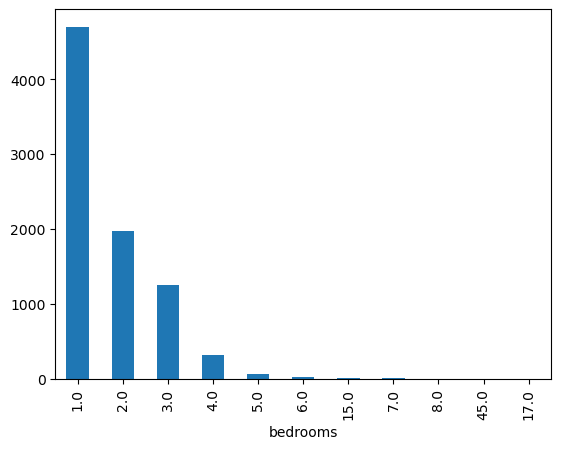

In [33]:
df.bedrooms.value_counts().plot.bar();

Vamos a discretizar para 1,2,3 y más de 3.

Podemos usar np.select

In [34]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms > 3]

resultados = ['01_Una','02_Dos','03_Tres','04_Cuatro o mas']

df['bedrooms_disc'] = np.select(condiciones, resultados, default = -999)

Comprobamos

In [35]:
df.bedrooms_disc.value_counts()

bedrooms_disc
01_Una             4700
02_Dos             1967
03_Tres            1248
04_Cuatro o mas     409
Name: count, dtype: int64

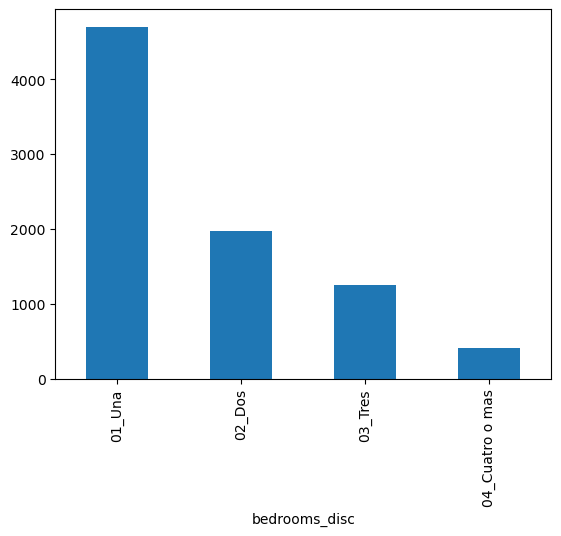

In [36]:
df.bedrooms_disc.value_counts().plot.bar();

#### **Discretizar accommodates, beds y number_of_reviews**

Vamos a usar qcut para discritizar con percentiles 0.45, 0.8, 1

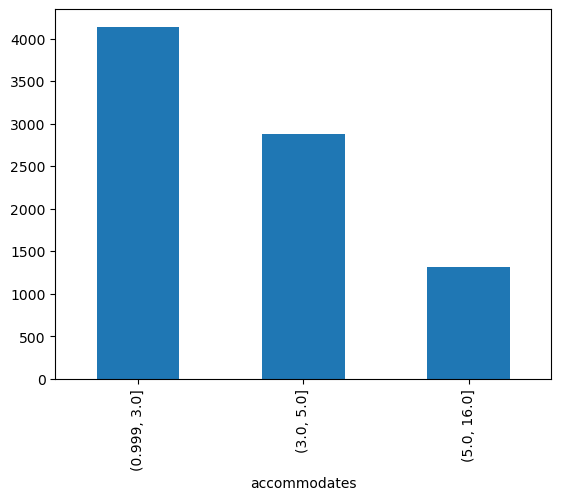

In [37]:
pd.qcut(df.accommodates,[0, 0.45, 0.8, 1]).value_counts().plot.bar();

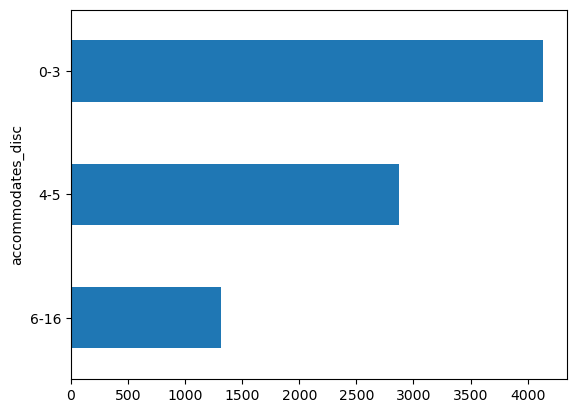

In [38]:
df['accommodates_disc'] = pd.qcut(df.accommodates,[0, 0.45, 0.8, 1],
                                 labels = ['0-3','4-5','6-16'])

df['accommodates_disc'].value_counts().sort_index(ascending = False).plot.barh();

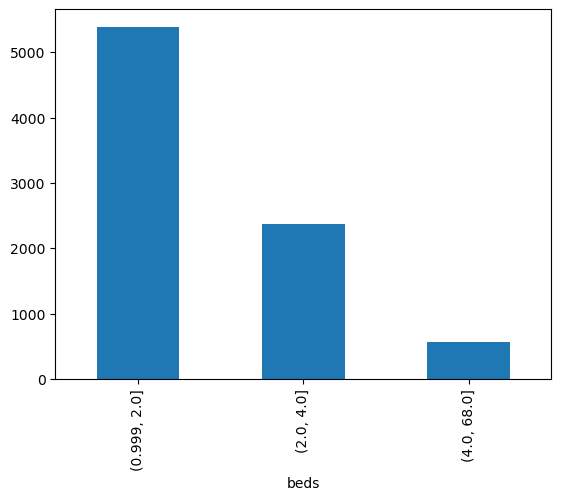

In [39]:
pd.qcut(df.beds,[0, 0.5, 0.85, 1]).value_counts().plot.bar();

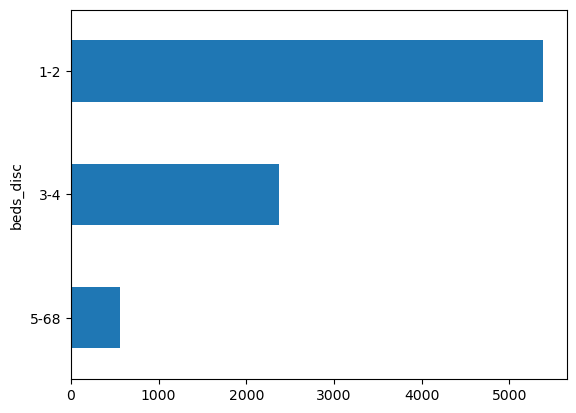

In [40]:
df['beds_disc'] = pd.qcut(df.beds,[0, 0.5, 0.85, 1],
                         labels = ['1-2','3-4','5-68'])

df['beds_disc'].value_counts().sort_index(ascending = False).plot.barh();

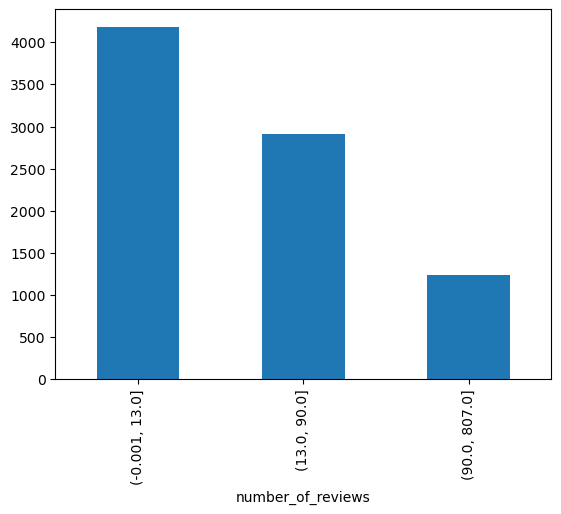

In [41]:
pd.qcut(df.number_of_reviews,[0, 0.5, 0.85, 1]).value_counts().plot.bar();

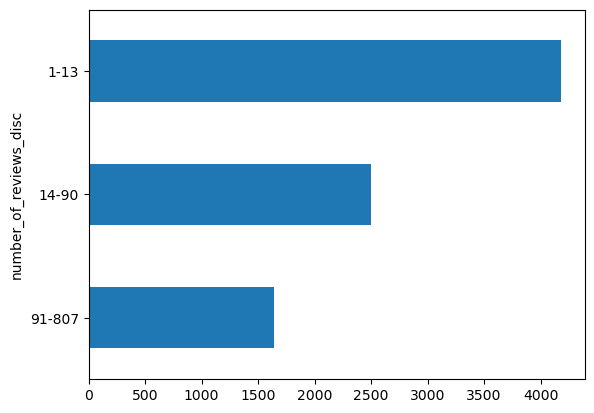

In [42]:
df['number_of_reviews_disc'] = pd.qcut(df.number_of_reviews,[0, 0.5, 0.8, 1],
                                      labels = ['1-13','14-90','91-807'])

df['number_of_reviews_disc'].value_counts().sort_index(ascending = False).plot.barh();

### Creación de variables con datos externos

- Palanca del precio del inmueble, la podemos estimar multiplicando los metros cuadrados del inmueble por el precio por m2.

- Al no disponer de los metros cuadrados del inmbueble, establecemos  criterios según número de habitaciones.

- No es perfecto, pero nos servirá de aproximación.

**Estimación de los metros cuadrados del inmueble**

Vamos usar el siguiente algoritmo:

* una habitación: m2 = 50
* dos habitaciones: m2 = 70
* tres habitaciones: m2 = 90
* cuatro habitaciones: m2 = 120
* cinco o más habitaciones: m2 = 150

In [43]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms == 4,
               df.bedrooms > 4]

resultados = [50,70,90,120,150]

df['m2'] = np.select(condiciones, resultados, default = -999)

Comprobamos

In [44]:
df['m2'].value_counts()

m2
50     4700
70     1967
90     1248
120     314
150      95
Name: count, dtype: int64

Ahora ya podemos estimar el precio de compra del inmueble.

Recordamos que al precio que nos sale le quitábamos un 30% por capacidad de negociación.

In [45]:
df['precio_compra'] = df.m2 * df.precio_m2 * 0.7

Comprobamos

In [46]:
df[['bedrooms','m2','distrito','precio_m2','precio_compra']].head(20)

,bedrooms,m2,distrito,precio_m2,precio_compra
0,2.0,70,LA SAIDIA,1951,95599.0
1,1.0,50,CIUTAT VELLA,3255,113925.0
2,3.0,90,EXTRAMURS,2670,168210.0
3,5.0,150,POBLATS MARITIMS,2168,227640.0
4,1.0,50,CIUTAT VELLA,3255,113925.0
5,5.0,150,POBLATS MARITIMS,2168,227640.0
6,1.0,50,CIUTAT VELLA,3255,113925.0
7,1.0,50,QUATRE CARRERES,2077,72695.0
8,1.0,50,EXTRAMURS,2670,93450.0
9,1.0,50,CIUTAT VELLA,3255,113925.0


**Calculo de variables punto de interés**

Vamos a calcular la distancia de cada inmueble al Oceanografic y plaza de la Virgen .

Para ello buscamos en Google su longitud y latitud: https://www.123coordenadas.com/

**Oceanografic**
Latitud: 39.4521628
Longitud: -0.3479952

**Plaza de la Virgen**
Latitud: 39.47639115
Longitud: -0.375277474765649

Dada la curvatura de la tierra la distancia entre dos puntos a partir de su latitud y longitud se calcula con una fórmula que se llama distancia de Haversine.


In [47]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

Creamos la variable

In [48]:
#Las coordenadas del Oceanografic  serán lat1 y lon1, plaza de la Virgen lat2 y lon2
lat1 = 39.4521628
lon1 = -0.3479952
lat2 = 39.47639115
lon2 =  -0.375277474765649

df['pdi_oceano'] = df.apply(lambda registro: haversine(lat1,lon1,registro.latitude,registro.longitude),axis = 1)
df['pdi_plaza'] = df.apply(lambda registro: haversine(lat2,lon2,registro.latitude,registro.longitude),axis = 1)

Comprobamos revisando la distancia media por distritos.

In [49]:
df.groupby('distrito').pdi_oceano.mean().sort_values()

distrito
CAMINS AL GRAU        1.457433
QUATRE CARRERES       1.696910
ALGIROS               2.311117
L'EIXAMPLE            2.442210
POBLATS MARITIMS      2.473822
EL PLA DEL REAL       2.556744
JESUS                 3.479681
CIUTAT VELLA          3.577753
EXTRAMURS             3.687867
BENIMACLET            3.869860
PATRAIX               4.190840
LA SAIDIA             4.400644
L'OLIVERETA           4.829963
RASCANYA              4.981120
CAMPANAR              5.315074
BENICALAP             5.891119
POBLATS DE L'OEST     7.917790
POBLATS DEL NORD      8.787810
POBLATS DEL SUD      13.210268
Name: pdi_oceano, dtype: float64

In [50]:
df.groupby('distrito').pdi_plaza.mean().sort_values()

distrito
CIUTAT VELLA          0.487432
LA SAIDIA             1.069296
EXTRAMURS             1.277371
EL PLA DEL REAL       1.559612
L'EIXAMPLE            1.586854
BENIMACLET            1.683013
CAMPANAR              1.850046
RASCANYA              1.985662
L'OLIVERETA           2.229172
BENICALAP             2.341120
PATRAIX               2.486172
QUATRE CARRERES       2.503309
ALGIROS               2.583722
JESUS                 2.750401
CAMINS AL GRAU        2.778769
POBLATS MARITIMS      4.017646
POBLATS DE L'OEST     4.401876
POBLATS DEL NORD      5.715007
POBLATS DEL SUD      16.299764
Name: pdi_plaza, dtype: float64

## GUARDAMOS EN EL DATAMART

Vamos a guardar esta version como df_preparado

In [51]:
df.to_sql('df_preparado', con = con, if_exists = 'replace')

8324